In [24]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [107]:
# sklearn imports

# import scoring and utility functions from sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.metrics import f1_score, make_scorer, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, LabelBinarizer, OneHotEncoder
from sklearn.compose import make_column_transformer
#
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [86]:
# import the necessary keras packages
from loader_util.preprocessing import ImageToArrayPreprocessor, AspectAwarePreprocessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.nn.conv import FCHeadNet
##
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from imutils import paths

In [27]:
cwd = os.getcwd()
df_dis = pd.read_csv(filepath_or_buffer=f"{cwd}//dis_data.csv")
df_dis.head()

,Col,Events,Average Zeroed Cap@174kHz,Average Zeroed Cap@224kHz,Average Zeroed Cap@287kHz,Average Zeroed Cap@368kHz,Average Zeroed Cap@473kHz,Average Zeroed Cap@607kHz,Average Zeroed Cap@779kHz,Average Zeroed Cap@1000kHz,Average Zeroed Cap@1284kHz,Average Zeroed Cap@1648kHz,Average Zeroed Cap@2115kHz,Average Zeroed Cap@2714kHz,Cell Type,Time Point in hours,Cell Numbers in Million
0,23.0,Feed,1.331,1.207,0.562,0.745,0.594,0.360,0.247,0.279,0.045,0.148,0.058,0.005,MG63,24,1.0
1,24.0,0,1.387,1.270,0.969,0.789,0.569,0.320,0.264,0.244,0.095,0.174,0.047,0.012,MG63,24,1.0
2,25.0,0,1.344,1.297,0.736,0.825,0.592,0.307,0.249,0.167,0.024,0.149,-0.029,0.057,MG63,24,1.0
3,26.0,0,1.305,1.183,0.661,0.705,0.524,0.306,0.273,0.184,0.054,0.071,-0.011,-0.024,MG63,24,1.0
4,27.0,0,1.345,1.052,0.692,0.787,0.577,0.359,0.263,0.265,0.031,0.102,-0.020,-0.043,MG63,24,1.0


In [28]:
# drop the unnamed and events cols
drop_cols = ['Col', 'Events']
df_dis = df_dis.drop(axis=1, columns=drop_cols)
df_dis.head()

,Average Zeroed Cap@174kHz,Average Zeroed Cap@224kHz,Average Zeroed Cap@287kHz,Average Zeroed Cap@368kHz,Average Zeroed Cap@473kHz,Average Zeroed Cap@607kHz,Average Zeroed Cap@779kHz,Average Zeroed Cap@1000kHz,Average Zeroed Cap@1284kHz,Average Zeroed Cap@1648kHz,Average Zeroed Cap@2115kHz,Average Zeroed Cap@2714kHz,Cell Type,Time Point in hours,Cell Numbers in Million
0,1.331,1.207,0.562,0.745,0.594,0.360,0.247,0.279,0.045,0.148,0.058,0.005,MG63,24,1.0
1,1.387,1.270,0.969,0.789,0.569,0.320,0.264,0.244,0.095,0.174,0.047,0.012,MG63,24,1.0
2,1.344,1.297,0.736,0.825,0.592,0.307,0.249,0.167,0.024,0.149,-0.029,0.057,MG63,24,1.0
3,1.305,1.183,0.661,0.705,0.524,0.306,0.273,0.184,0.054,0.071,-0.011,-0.024,MG63,24,1.0
4,1.345,1.052,0.692,0.787,0.577,0.359,0.263,0.265,0.031,0.102,-0.020,-0.043,MG63,24,1.0


In [29]:
# rename the cols
target_columns = ['cell_type', 'cell_num', 'time']
new_col_names = []
for name in df_dis.columns:
    if "@" in name:
        new_name = 'f_' + name.split('@')[-1][:-3]
        new_col_names.append(new_name)
new_col_names.extend(target_columns)
df_dis.columns = new_col_names

# reorder the cols
df_dis = df_dis[list(df_dis.columns[:-3]) + ['cell_type', 'cell_num', 'time']]

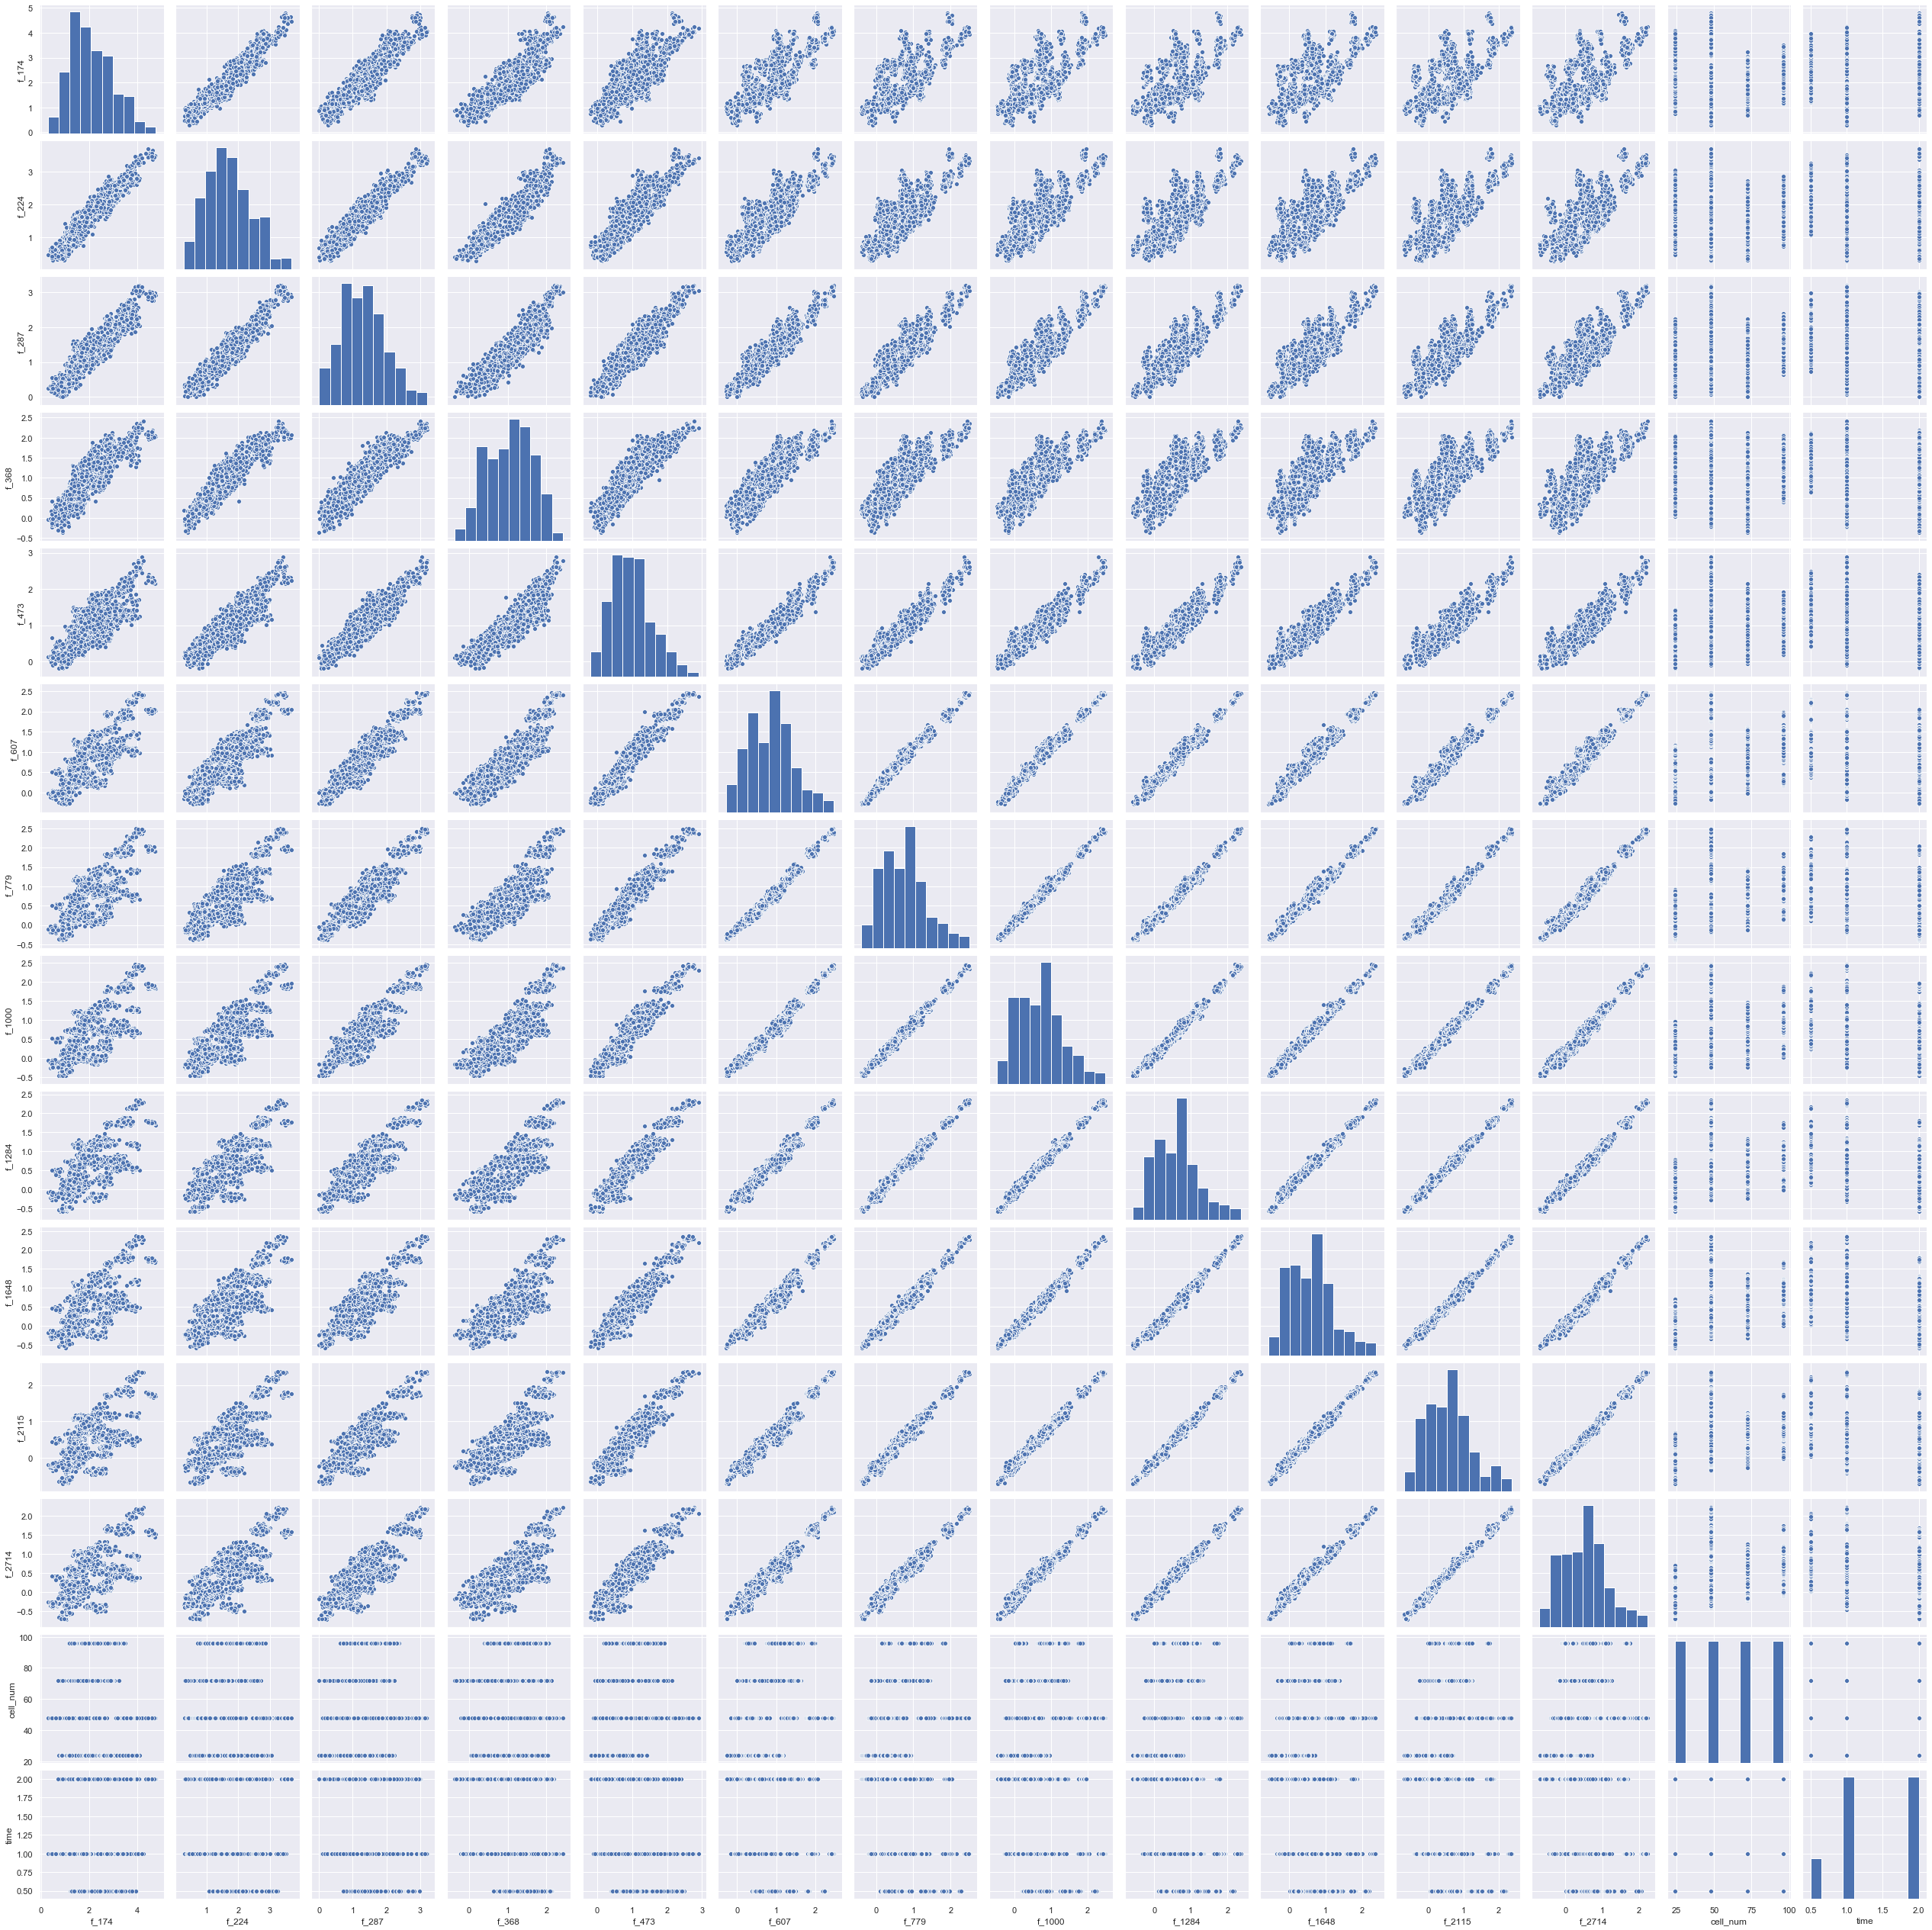

In [30]:
sns.pairplot(df_dis)

In [30]:
# get the X's and Y's
Y = df_dis[target_columns]
X = df_dis.drop(columns=target_columns)

In [31]:
# do feature target transformations
le = LabelEncoder()
scaler = StandardScaler()

X_transformed = scaler.fit_transform(X)
Y_transformed_cell_type = le.fit_transform(Y['cell_type'])

In [32]:
# split the dataset
trainx, testx, trainy, testy = train_test_split(X_transformed,
                                                Y_transformed_cell_type,
                                                test_size=0.3,
                                                random_state=42)

In [33]:
logreg = LogisticRegression(solver='lbfgs', multi_class='auto')
fit = logreg.fit(trainx, trainy)

In [34]:
preds = logreg.predict(testx)
print(classification_report(testy, preds))

              precision    recall  f1-score   support

           0       0.65      0.66      0.65       133
           1       0.77      0.75      0.76       146
           2       0.92      0.93      0.92       225

    accuracy                           0.81       504
   macro avg       0.78      0.78      0.78       504
weighted avg       0.81      0.81      0.81       504



In [35]:

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

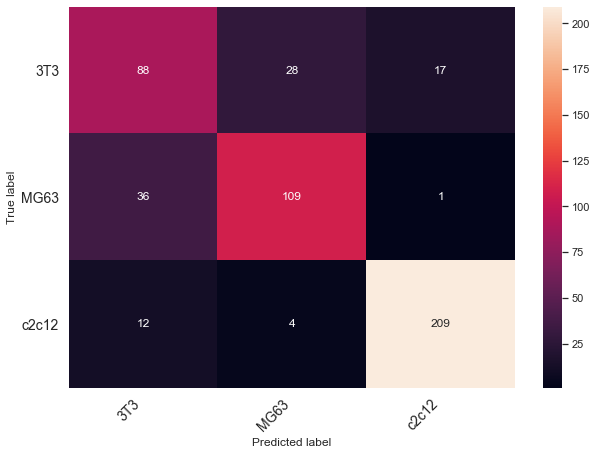

In [36]:
class_names = np.unique(Y['cell_type'])
cm = confusion_matrix(testy, preds)
print_confusion_matrix(cm, class_names=class_names)

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       133
           1       0.85      0.83      0.84       146
           2       0.95      0.93      0.94       225

    accuracy                           0.88       504
   macro avg       0.87      0.87      0.87       504
weighted avg       0.88      0.88      0.88       504



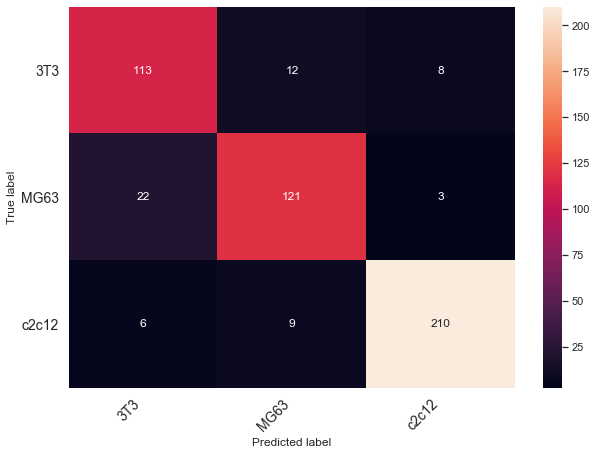

In [37]:
dtree = DecisionTreeClassifier()
dtree.fit(trainx, trainy)
preds = dtree.predict(testx)
print(classification_report(testy, preds))
cm = confusion_matrix(testy, preds)
print_confusion_matrix(cm, class_names=class_names)

              precision    recall  f1-score   support

           0       0.72      0.65      0.69       133
           1       0.83      0.70      0.76       146
           2       0.83      0.96      0.89       225

    accuracy                           0.80       504
   macro avg       0.79      0.77      0.78       504
weighted avg       0.80      0.80      0.80       504



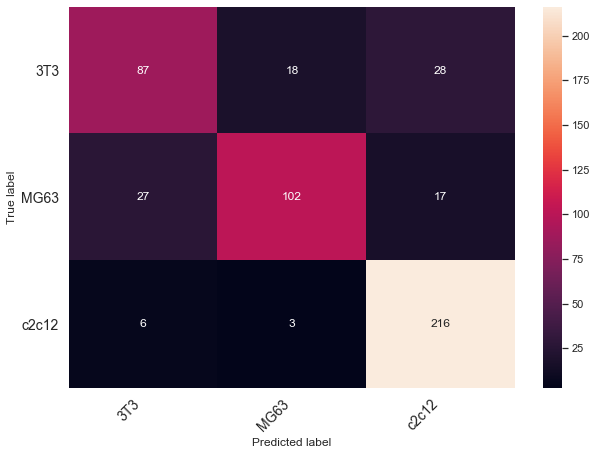

In [38]:
svc = SVC(kernel='rbf')
svc.fit(trainx, trainy)
preds = svc.predict(testx)
print(classification_report(testy, preds))
cm = confusion_matrix(testy, preds)
print_confusion_matrix(cm, class_names=class_names)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       133
           1       0.96      0.95      0.95       146
           2       1.00      0.99      0.99       225

    accuracy                           0.97       504
   macro avg       0.96      0.96      0.96       504
weighted avg       0.97      0.97      0.97       504



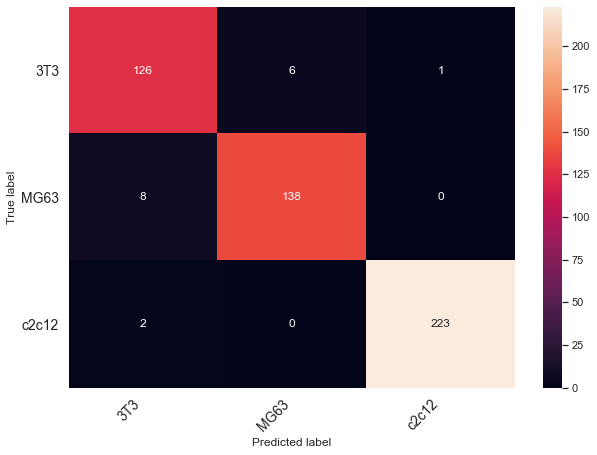

In [39]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(trainx, trainy)
preds = knn.predict(testx)
print(classification_report(testy, preds))
cm = confusion_matrix(testy, preds)
print_confusion_matrix(cm, class_names=class_names)

In [61]:
mlb = MultiLabelBinarizer()
Y_transformed_multilabel = mlb.fit_transform(Y.to_numpy().astype(str))

In [62]:
# create the ANN model
model = Sequential()
model.add(Dense(units=64, input_shape=(X_transformed.shape[1],)))
model.add(Activation("relu"))
model.add(Bat)
model.add(Dense(units=32))
model.add(Activation("relu"))
model.add(Dense(units=16))
model.add(Activation("relu"))
model.add(Dense(units=len(mlb.classes_)))
model.add(Activation("sigmoid"))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                832       
_________________________________________________________________
activation_14 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
activation_15 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                528       
_________________________________________________________________
activation_16 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)               

In [97]:
lb = LabelBinarizer()
Y_transformed_cell_type_ann = lb.fit_transform(Y['time'].to_numpy().astype(str))
Y_transformed_cell_type_ann

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [ ]:
# create the ANN model for multilabel
model = Sequential()
model.add(Dense(units=64, input_shape=(X_transformed.shape[1],)))
model.add(Activation("relu"))
model.add(Dense(units=32))
model.add(Activation("relu"))
model.add(Dense(units=16))
model.add(Activation("relu"))
model.add(Dense(units=len(mlb.classes_)))
model.add(Activation("sigmoid"))
model.summary()

In [98]:
# create the ANN model for one label
model = Sequential()
model.add(Dense(units=64, input_shape=(X_transformed.shape[1],)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(units=32))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(units=16))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(units=len(lb.classes_)))
model.add(Activation("softmax"))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 64)                832       
_________________________________________________________________
activation_40 (Activation)   (None, 64)                0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 64)                256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 32)                2080      
_________________________________________________________________
activation_41 (Activation)   (None, 32)                0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 32)              

In [63]:
# create our custom accuracy score
def multilabel_accuracy(y_true, y_pred: tf.Tensor):


    preds_binarised = tf.where(y_pred >= 0.5, 1.0, 0.0)

    temp1 = y_true == preds_binarised
    temp2 = tf.where(temp1 == True, 1.0, 0.0)

    sum_array = K.sum(temp2, axis=1)
    all_correct_rows = tf.where(sum_array == 7, 1.0, 0.0)
    multilabel_accuracy_ = K.mean(all_correct_rows)

    return multilabel_accuracy_

In [99]:
# split the dataset
trainx, testx, trainy, testy = train_test_split(X_transformed,
                                                Y_transformed_cell_type_ann,
                                                test_size=0.3,
                                                random_state=42)

In [100]:
# init some global variables
epochs = 1000
init_lr = 1e-3


# compile the model and start training
opt = Adam(learning_rate=init_lr, decay=init_lr/epochs)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

H = model.fit(trainx, trainy,
              validation_data=(testx, testy),
              verbose=1,
              epochs=epochs)

Train on 1176 samples, validate on 504 samples
Epoch 1/1000
1176/1176 [==============================] - 2s 1ms/sample - loss: 1.5221 - accuracy: 0.3427 - val_loss: 1.0483 - val_accuracy: 0.4325
Epoch 2/1000
1176/1176 [==============================] - 0s 116us/sample - loss: 1.3687 - accuracy: 0.3937 - val_loss: 0.9852 - val_accuracy: 0.5813
Epoch 3/1000
1176/1176 [==============================] - 0s 120us/sample - loss: 1.1872 - accuracy: 0.4549 - val_loss: 0.9397 - val_accuracy: 0.6032
Epoch 4/1000
1176/1176 [==============================] - 0s 123us/sample - loss: 1.1273 - accuracy: 0.4660 - val_loss: 0.9055 - val_accuracy: 0.6647
Epoch 5/1000
1176/1176 [==============================] - 0s 109us/sample - loss: 1.0468 - accuracy: 0.5017 - val_loss: 0.8767 - val_accuracy: 0.6647
Epoch 6/1000
1176/1176 [==============================] - 0s 115us/sample - loss: 1.0259 - accuracy: 0.5255 - val_loss: 0.8476 - val_accuracy: 0.6746
Epoch 7/1000
1176/1176 [==============================]

Epoch 55/1000
1176/1176 [==============================] - 0s 104us/sample - loss: 0.6443 - accuracy: 0.7075 - val_loss: 0.5029 - val_accuracy: 0.7460
Epoch 56/1000
1176/1176 [==============================] - 0s 105us/sample - loss: 0.6498 - accuracy: 0.7041 - val_loss: 0.5010 - val_accuracy: 0.7440
Epoch 57/1000
1176/1176 [==============================] - 0s 102us/sample - loss: 0.6728 - accuracy: 0.6930 - val_loss: 0.5097 - val_accuracy: 0.7460
Epoch 58/1000
1176/1176 [==============================] - 0s 114us/sample - loss: 0.6309 - accuracy: 0.7347 - val_loss: 0.5143 - val_accuracy: 0.7421
Epoch 59/1000
1176/1176 [==============================] - 0s 105us/sample - loss: 0.6453 - accuracy: 0.7092 - val_loss: 0.4941 - val_accuracy: 0.7480
Epoch 60/1000
1176/1176 [==============================] - 0s 103us/sample - loss: 0.6279 - accuracy: 0.7143 - val_loss: 0.4928 - val_accuracy: 0.7560
Epoch 61/1000
1176/1176 [==============================] - 0s 106us/sample - loss: 0.6292 - ac

1176/1176 [==============================] - 0s 116us/sample - loss: 0.5876 - accuracy: 0.7491 - val_loss: 0.4578 - val_accuracy: 0.8075
Epoch 110/1000
1176/1176 [==============================] - 0s 117us/sample - loss: 0.5941 - accuracy: 0.7389 - val_loss: 0.4436 - val_accuracy: 0.7937
Epoch 111/1000
1176/1176 [==============================] - 0s 124us/sample - loss: 0.5707 - accuracy: 0.7474 - val_loss: 0.4251 - val_accuracy: 0.7956
Epoch 112/1000
1176/1176 [==============================] - 0s 121us/sample - loss: 0.5523 - accuracy: 0.7423 - val_loss: 0.4298 - val_accuracy: 0.7956
Epoch 113/1000
1176/1176 [==============================] - 0s 108us/sample - loss: 0.5560 - accuracy: 0.7491 - val_loss: 0.4296 - val_accuracy: 0.7976
Epoch 114/1000
1176/1176 [==============================] - 0s 111us/sample - loss: 0.5647 - accuracy: 0.7347 - val_loss: 0.4318 - val_accuracy: 0.7956
Epoch 115/1000
1176/1176 [==============================] - 0s 120us/sample - loss: 0.5579 - accuracy: 

Epoch 163/1000
1176/1176 [==============================] - 0s 110us/sample - loss: 0.5344 - accuracy: 0.7645 - val_loss: 0.3758 - val_accuracy: 0.8234
Epoch 164/1000
1176/1176 [==============================] - 0s 110us/sample - loss: 0.5294 - accuracy: 0.7636 - val_loss: 0.4143 - val_accuracy: 0.8135
Epoch 165/1000
1176/1176 [==============================] - 0s 102us/sample - loss: 0.5261 - accuracy: 0.7874 - val_loss: 0.4136 - val_accuracy: 0.8075
Epoch 166/1000
1176/1176 [==============================] - 0s 114us/sample - loss: 0.5178 - accuracy: 0.7738 - val_loss: 0.3855 - val_accuracy: 0.8214
Epoch 167/1000
1176/1176 [==============================] - 0s 109us/sample - loss: 0.5278 - accuracy: 0.7594 - val_loss: 0.3694 - val_accuracy: 0.8333
Epoch 168/1000
1176/1176 [==============================] - 0s 107us/sample - loss: 0.5289 - accuracy: 0.7823 - val_loss: 0.3748 - val_accuracy: 0.8393
Epoch 169/1000
1176/1176 [==============================] - 0s 110us/sample - loss: 0.49

Epoch 217/1000
1176/1176 [==============================] - 0s 108us/sample - loss: 0.5168 - accuracy: 0.7670 - val_loss: 0.3628 - val_accuracy: 0.8274
Epoch 218/1000
1176/1176 [==============================] - 0s 105us/sample - loss: 0.4479 - accuracy: 0.8019 - val_loss: 0.3632 - val_accuracy: 0.8333
Epoch 219/1000
1176/1176 [==============================] - 0s 111us/sample - loss: 0.5056 - accuracy: 0.7781 - val_loss: 0.3725 - val_accuracy: 0.8294
Epoch 220/1000
1176/1176 [==============================] - 0s 105us/sample - loss: 0.4932 - accuracy: 0.7798 - val_loss: 0.3737 - val_accuracy: 0.8175
Epoch 221/1000
1176/1176 [==============================] - 0s 108us/sample - loss: 0.5066 - accuracy: 0.7645 - val_loss: 0.3673 - val_accuracy: 0.8254
Epoch 222/1000
1176/1176 [==============================] - 0s 132us/sample - loss: 0.4886 - accuracy: 0.7815 - val_loss: 0.3566 - val_accuracy: 0.8353
Epoch 223/1000
1176/1176 [==============================] - 0s 112us/sample - loss: 0.50

Epoch 271/1000
1176/1176 [==============================] - 0s 106us/sample - loss: 0.4937 - accuracy: 0.7840 - val_loss: 0.3874 - val_accuracy: 0.8095
Epoch 272/1000
1176/1176 [==============================] - 0s 109us/sample - loss: 0.5018 - accuracy: 0.7815 - val_loss: 0.3670 - val_accuracy: 0.8274
Epoch 273/1000
1176/1176 [==============================] - 0s 106us/sample - loss: 0.4609 - accuracy: 0.8095 - val_loss: 0.3453 - val_accuracy: 0.8333
Epoch 274/1000
1176/1176 [==============================] - 0s 109us/sample - loss: 0.4711 - accuracy: 0.7815 - val_loss: 0.3557 - val_accuracy: 0.8333
Epoch 275/1000
1176/1176 [==============================] - 0s 107us/sample - loss: 0.4650 - accuracy: 0.8027 - val_loss: 0.3700 - val_accuracy: 0.8234
Epoch 276/1000
1176/1176 [==============================] - 0s 102us/sample - loss: 0.4631 - accuracy: 0.7993 - val_loss: 0.3642 - val_accuracy: 0.8313
Epoch 277/1000
1176/1176 [==============================] - 0s 107us/sample - loss: 0.48

Epoch 325/1000
1176/1176 [==============================] - 0s 111us/sample - loss: 0.4736 - accuracy: 0.7959 - val_loss: 0.3623 - val_accuracy: 0.8254
Epoch 326/1000
1176/1176 [==============================] - 0s 107us/sample - loss: 0.4368 - accuracy: 0.8146 - val_loss: 0.3468 - val_accuracy: 0.8333
Epoch 327/1000
1176/1176 [==============================] - 0s 115us/sample - loss: 0.4242 - accuracy: 0.8189 - val_loss: 0.3559 - val_accuracy: 0.8234
Epoch 328/1000
1176/1176 [==============================] - 0s 110us/sample - loss: 0.4844 - accuracy: 0.7993 - val_loss: 0.3485 - val_accuracy: 0.8234
Epoch 329/1000
1176/1176 [==============================] - 0s 125us/sample - loss: 0.4459 - accuracy: 0.8206 - val_loss: 0.3520 - val_accuracy: 0.8313
Epoch 330/1000
1176/1176 [==============================] - 0s 110us/sample - loss: 0.4502 - accuracy: 0.8112 - val_loss: 0.3309 - val_accuracy: 0.8373
Epoch 331/1000
1176/1176 [==============================] - 0s 103us/sample - loss: 0.48

Epoch 379/1000
1176/1176 [==============================] - 0s 118us/sample - loss: 0.4362 - accuracy: 0.8044 - val_loss: 0.3372 - val_accuracy: 0.8333
Epoch 380/1000
1176/1176 [==============================] - 0s 111us/sample - loss: 0.4625 - accuracy: 0.7993 - val_loss: 0.3473 - val_accuracy: 0.8294
Epoch 381/1000
1176/1176 [==============================] - 0s 106us/sample - loss: 0.4358 - accuracy: 0.8146 - val_loss: 0.3476 - val_accuracy: 0.8472
Epoch 382/1000
1176/1176 [==============================] - 0s 102us/sample - loss: 0.4652 - accuracy: 0.8180 - val_loss: 0.3362 - val_accuracy: 0.8313
Epoch 383/1000
1176/1176 [==============================] - 0s 122us/sample - loss: 0.4363 - accuracy: 0.8197 - val_loss: 0.3695 - val_accuracy: 0.8353
Epoch 384/1000
1176/1176 [==============================] - 0s 121us/sample - loss: 0.4975 - accuracy: 0.8053 - val_loss: 0.3580 - val_accuracy: 0.8254
Epoch 385/1000
1176/1176 [==============================] - 0s 116us/sample - loss: 0.46

Epoch 433/1000
1176/1176 [==============================] - 0s 154us/sample - loss: 0.4514 - accuracy: 0.8053 - val_loss: 0.3718 - val_accuracy: 0.8274
Epoch 434/1000
1176/1176 [==============================] - 0s 153us/sample - loss: 0.4371 - accuracy: 0.8248 - val_loss: 0.3372 - val_accuracy: 0.8472
Epoch 435/1000
1176/1176 [==============================] - 0s 143us/sample - loss: 0.4529 - accuracy: 0.8087 - val_loss: 0.3320 - val_accuracy: 0.8393
Epoch 436/1000
1176/1176 [==============================] - 0s 119us/sample - loss: 0.4656 - accuracy: 0.8121 - val_loss: 0.3195 - val_accuracy: 0.8373
Epoch 437/1000
1176/1176 [==============================] - 0s 133us/sample - loss: 0.4451 - accuracy: 0.8172 - val_loss: 0.3135 - val_accuracy: 0.8472
Epoch 438/1000
1176/1176 [==============================] - 0s 156us/sample - loss: 0.4572 - accuracy: 0.8078 - val_loss: 0.3130 - val_accuracy: 0.8512
Epoch 439/1000
1176/1176 [==============================] - 0s 139us/sample - loss: 0.46

Epoch 487/1000
1176/1176 [==============================] - 0s 114us/sample - loss: 0.4406 - accuracy: 0.8214 - val_loss: 0.3468 - val_accuracy: 0.8433
Epoch 488/1000
1176/1176 [==============================] - 0s 135us/sample - loss: 0.4407 - accuracy: 0.8206 - val_loss: 0.3642 - val_accuracy: 0.8353
Epoch 489/1000
1176/1176 [==============================] - 0s 105us/sample - loss: 0.4469 - accuracy: 0.8095 - val_loss: 0.3434 - val_accuracy: 0.8333
Epoch 490/1000
1176/1176 [==============================] - 0s 122us/sample - loss: 0.4201 - accuracy: 0.8197 - val_loss: 0.3438 - val_accuracy: 0.8254
Epoch 491/1000
1176/1176 [==============================] - 0s 114us/sample - loss: 0.4602 - accuracy: 0.8104 - val_loss: 0.3477 - val_accuracy: 0.8353
Epoch 492/1000
1176/1176 [==============================] - 0s 101us/sample - loss: 0.4469 - accuracy: 0.8044 - val_loss: 0.3449 - val_accuracy: 0.8413
Epoch 493/1000
1176/1176 [==============================] - 0s 102us/sample - loss: 0.44

Epoch 541/1000
1176/1176 [==============================] - 0s 106us/sample - loss: 0.4515 - accuracy: 0.8231 - val_loss: 0.3216 - val_accuracy: 0.8611
Epoch 542/1000
1176/1176 [==============================] - 0s 102us/sample - loss: 0.4300 - accuracy: 0.8240 - val_loss: 0.3220 - val_accuracy: 0.8433
Epoch 543/1000
1176/1176 [==============================] - 0s 114us/sample - loss: 0.4361 - accuracy: 0.8121 - val_loss: 0.3118 - val_accuracy: 0.8452
Epoch 544/1000
1176/1176 [==============================] - 0s 98us/sample - loss: 0.4452 - accuracy: 0.8061 - val_loss: 0.3232 - val_accuracy: 0.8294
Epoch 545/1000
1176/1176 [==============================] - 0s 101us/sample - loss: 0.4482 - accuracy: 0.8044 - val_loss: 0.3262 - val_accuracy: 0.8413
Epoch 546/1000
1176/1176 [==============================] - 0s 98us/sample - loss: 0.4491 - accuracy: 0.8146 - val_loss: 0.3325 - val_accuracy: 0.8452
Epoch 547/1000
1176/1176 [==============================] - 0s 98us/sample - loss: 0.4244 

Epoch 595/1000
1176/1176 [==============================] - 0s 103us/sample - loss: 0.4361 - accuracy: 0.8172 - val_loss: 0.3281 - val_accuracy: 0.8254
Epoch 596/1000
1176/1176 [==============================] - 0s 105us/sample - loss: 0.3892 - accuracy: 0.8316 - val_loss: 0.3449 - val_accuracy: 0.8294
Epoch 597/1000
1176/1176 [==============================] - 0s 106us/sample - loss: 0.4235 - accuracy: 0.8325 - val_loss: 0.3326 - val_accuracy: 0.8433
Epoch 598/1000
1176/1176 [==============================] - 0s 103us/sample - loss: 0.4522 - accuracy: 0.8002 - val_loss: 0.3420 - val_accuracy: 0.8313
Epoch 599/1000
1176/1176 [==============================] - 0s 104us/sample - loss: 0.3820 - accuracy: 0.8316 - val_loss: 0.3283 - val_accuracy: 0.8373
Epoch 600/1000
1176/1176 [==============================] - 0s 93us/sample - loss: 0.4161 - accuracy: 0.8393 - val_loss: 0.3329 - val_accuracy: 0.8353
Epoch 601/1000
1176/1176 [==============================] - 0s 97us/sample - loss: 0.4406

1176/1176 [==============================] - 0s 98us/sample - loss: 0.4318 - accuracy: 0.8146 - val_loss: 0.3224 - val_accuracy: 0.8512
Epoch 650/1000
1176/1176 [==============================] - 0s 94us/sample - loss: 0.4375 - accuracy: 0.8206 - val_loss: 0.3115 - val_accuracy: 0.8532
Epoch 651/1000
1176/1176 [==============================] - 0s 96us/sample - loss: 0.4033 - accuracy: 0.8469 - val_loss: 0.3382 - val_accuracy: 0.8274
Epoch 652/1000
1176/1176 [==============================] - 0s 104us/sample - loss: 0.4475 - accuracy: 0.8095 - val_loss: 0.3138 - val_accuracy: 0.8433
Epoch 653/1000
1176/1176 [==============================] - 0s 105us/sample - loss: 0.4256 - accuracy: 0.8291 - val_loss: 0.3145 - val_accuracy: 0.8571
Epoch 654/1000
1176/1176 [==============================] - 0s 101us/sample - loss: 0.4059 - accuracy: 0.8359 - val_loss: 0.3078 - val_accuracy: 0.8472
Epoch 655/1000
1176/1176 [==============================] - 0s 108us/sample - loss: 0.4307 - accuracy: 0.8

1176/1176 [==============================] - 0s 164us/sample - loss: 0.4334 - accuracy: 0.8299 - val_loss: 0.2992 - val_accuracy: 0.8591
Epoch 704/1000
1176/1176 [==============================] - 0s 153us/sample - loss: 0.4045 - accuracy: 0.8367 - val_loss: 0.3290 - val_accuracy: 0.8353
Epoch 705/1000
1176/1176 [==============================] - 0s 131us/sample - loss: 0.4057 - accuracy: 0.8248 - val_loss: 0.3215 - val_accuracy: 0.8552
Epoch 706/1000
1176/1176 [==============================] - 0s 163us/sample - loss: 0.4186 - accuracy: 0.8316 - val_loss: 0.3130 - val_accuracy: 0.8552
Epoch 707/1000
1176/1176 [==============================] - 0s 166us/sample - loss: 0.4022 - accuracy: 0.8359 - val_loss: 0.3137 - val_accuracy: 0.8512
Epoch 708/1000
1176/1176 [==============================] - 0s 175us/sample - loss: 0.3882 - accuracy: 0.8325 - val_loss: 0.3196 - val_accuracy: 0.8472
Epoch 709/1000
1176/1176 [==============================] - 0s 162us/sample - loss: 0.4061 - accuracy: 

Epoch 757/1000
1176/1176 [==============================] - 0s 111us/sample - loss: 0.3867 - accuracy: 0.8418 - val_loss: 0.2974 - val_accuracy: 0.8472
Epoch 758/1000
1176/1176 [==============================] - 0s 106us/sample - loss: 0.4338 - accuracy: 0.8248 - val_loss: 0.3165 - val_accuracy: 0.8472
Epoch 759/1000
1176/1176 [==============================] - 0s 108us/sample - loss: 0.4008 - accuracy: 0.8359 - val_loss: 0.2927 - val_accuracy: 0.8611
Epoch 760/1000
1176/1176 [==============================] - 0s 126us/sample - loss: 0.3862 - accuracy: 0.8350 - val_loss: 0.3061 - val_accuracy: 0.8571
Epoch 761/1000
1176/1176 [==============================] - 0s 115us/sample - loss: 0.4340 - accuracy: 0.8401 - val_loss: 0.3118 - val_accuracy: 0.8512
Epoch 762/1000
1176/1176 [==============================] - 0s 114us/sample - loss: 0.3987 - accuracy: 0.8384 - val_loss: 0.3120 - val_accuracy: 0.8492
Epoch 763/1000
1176/1176 [==============================] - 0s 114us/sample - loss: 0.39

Epoch 811/1000
1176/1176 [==============================] - 0s 112us/sample - loss: 0.4000 - accuracy: 0.8410 - val_loss: 0.2987 - val_accuracy: 0.8512
Epoch 812/1000
1176/1176 [==============================] - 0s 114us/sample - loss: 0.4118 - accuracy: 0.8393 - val_loss: 0.3116 - val_accuracy: 0.8294
Epoch 813/1000
1176/1176 [==============================] - 0s 121us/sample - loss: 0.3971 - accuracy: 0.8469 - val_loss: 0.3162 - val_accuracy: 0.8393
Epoch 814/1000
1176/1176 [==============================] - 0s 114us/sample - loss: 0.4101 - accuracy: 0.8350 - val_loss: 0.3294 - val_accuracy: 0.8373
Epoch 815/1000
1176/1176 [==============================] - 0s 109us/sample - loss: 0.4001 - accuracy: 0.8427 - val_loss: 0.3155 - val_accuracy: 0.8532
Epoch 816/1000
1176/1176 [==============================] - 0s 110us/sample - loss: 0.3994 - accuracy: 0.8342 - val_loss: 0.3394 - val_accuracy: 0.8313
Epoch 817/1000
1176/1176 [==============================] - 0s 112us/sample - loss: 0.40

Epoch 865/1000
1176/1176 [==============================] - 0s 115us/sample - loss: 0.3822 - accuracy: 0.8376 - val_loss: 0.3154 - val_accuracy: 0.8492
Epoch 866/1000
1176/1176 [==============================] - 0s 107us/sample - loss: 0.4231 - accuracy: 0.8350 - val_loss: 0.2949 - val_accuracy: 0.8552
Epoch 867/1000
1176/1176 [==============================] - 0s 108us/sample - loss: 0.3740 - accuracy: 0.8461 - val_loss: 0.2976 - val_accuracy: 0.8472
Epoch 868/1000
1176/1176 [==============================] - 0s 124us/sample - loss: 0.4161 - accuracy: 0.8359 - val_loss: 0.3068 - val_accuracy: 0.8433
Epoch 869/1000
1176/1176 [==============================] - 0s 112us/sample - loss: 0.3577 - accuracy: 0.8597 - val_loss: 0.2866 - val_accuracy: 0.8591
Epoch 870/1000
1176/1176 [==============================] - 0s 113us/sample - loss: 0.4177 - accuracy: 0.8282 - val_loss: 0.2887 - val_accuracy: 0.8671
Epoch 871/1000
1176/1176 [==============================] - 0s 115us/sample - loss: 0.41

1176/1176 [==============================] - 0s 103us/sample - loss: 0.3649 - accuracy: 0.8563 - val_loss: 0.2998 - val_accuracy: 0.8591
Epoch 919/1000
1176/1176 [==============================] - 0s 104us/sample - loss: 0.4117 - accuracy: 0.8410 - val_loss: 0.2938 - val_accuracy: 0.8591
Epoch 920/1000
1176/1176 [==============================] - 0s 106us/sample - loss: 0.3649 - accuracy: 0.8418 - val_loss: 0.2984 - val_accuracy: 0.8571
Epoch 921/1000
1176/1176 [==============================] - 0s 108us/sample - loss: 0.4008 - accuracy: 0.8469 - val_loss: 0.2919 - val_accuracy: 0.8611
Epoch 922/1000
1176/1176 [==============================] - 0s 103us/sample - loss: 0.3935 - accuracy: 0.8478 - val_loss: 0.3029 - val_accuracy: 0.8492
Epoch 923/1000
1176/1176 [==============================] - 0s 100us/sample - loss: 0.3903 - accuracy: 0.8478 - val_loss: 0.2941 - val_accuracy: 0.8433
Epoch 924/1000
1176/1176 [==============================] - 0s 106us/sample - loss: 0.4160 - accuracy: 

1176/1176 [==============================] - 0s 113us/sample - loss: 0.3792 - accuracy: 0.8367 - val_loss: 0.2852 - val_accuracy: 0.8591
Epoch 973/1000
1176/1176 [==============================] - 0s 98us/sample - loss: 0.3612 - accuracy: 0.8656 - val_loss: 0.3063 - val_accuracy: 0.8472
Epoch 974/1000
1176/1176 [==============================] - 0s 100us/sample - loss: 0.3911 - accuracy: 0.8461 - val_loss: 0.3017 - val_accuracy: 0.8552
Epoch 975/1000
1176/1176 [==============================] - 0s 96us/sample - loss: 0.3708 - accuracy: 0.8503 - val_loss: 0.3310 - val_accuracy: 0.8591
Epoch 976/1000
1176/1176 [==============================] - 0s 123us/sample - loss: 0.3635 - accuracy: 0.8495 - val_loss: 0.3135 - val_accuracy: 0.8552
Epoch 977/1000
1176/1176 [==============================] - 0s 103us/sample - loss: 0.3822 - accuracy: 0.8503 - val_loss: 0.3109 - val_accuracy: 0.8393
Epoch 978/1000
1176/1176 [==============================] - 0s 98us/sample - loss: 0.3816 - accuracy: 0.8

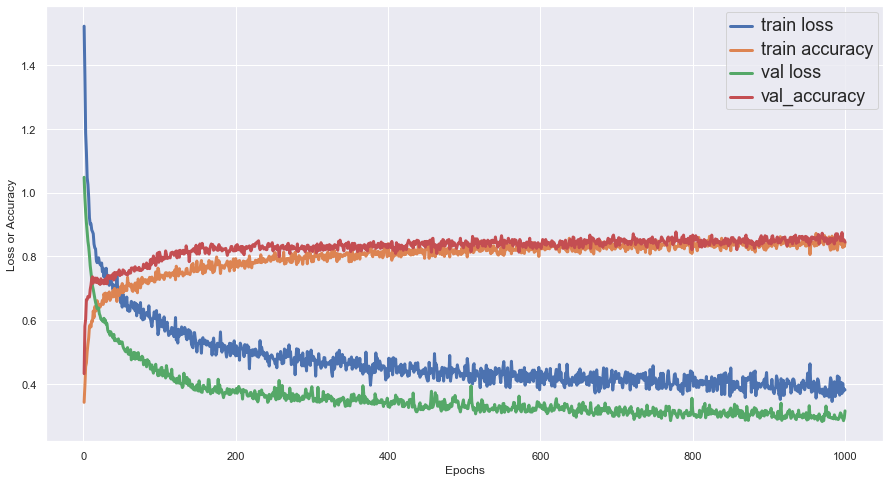

In [101]:
# plot the performance
epoch_num = range(1,epochs+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epoch_num,
                                  loss,accuracy,
                                  val_loss,
                                  val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [102]:
X

,f_174,f_224,f_287,f_368,f_473,f_607,f_779,f_1000,f_1284,f_1648,f_2115,f_2714
0,1.331,1.207,0.562,0.745,0.594,0.360,0.247,0.279,0.045,0.148,0.058,0.005
1,1.387,1.270,0.969,0.789,0.569,0.320,0.264,0.244,0.095,0.174,0.047,0.012
2,1.344,1.297,0.736,0.825,0.592,0.307,0.249,0.167,0.024,0.149,-0.029,0.057
3,1.305,1.183,0.661,0.705,0.524,0.306,0.273,0.184,0.054,0.071,-0.011,-0.024
4,1.345,1.052,0.692,0.787,0.577,0.359,0.263,0.265,0.031,0.102,-0.020,-0.043
...,...,...,...,...,...,...,...,...,...,...,...,...
1675,3.051,2.575,1.674,1.759,1.385,1.598,1.416,1.359,1.178,1.120,1.233,1.111
1676,2.876,2.517,2.085,1.672,1.355,1.564,1.433,1.398,1.185,1.053,1.249,1.066
1677,2.874,2.570,2.108,1.768,1.480,1.501,1.312,1.363,1.169,1.165,1.221,1.097
1678,2.841,2.359,2.061,1.740,1.371,1.524,1.355,1.425,1.138,1.154,1.150,1.160


In [105]:
X['cell_type'] = df_dis['cell_type']
X

,f_174,f_224,f_287,f_368,f_473,f_607,f_779,f_1000,f_1284,f_1648,f_2115,f_2714,cell_type
0,1.331,1.207,0.562,0.745,0.594,0.360,0.247,0.279,0.045,0.148,0.058,0.005,MG63
1,1.387,1.270,0.969,0.789,0.569,0.320,0.264,0.244,0.095,0.174,0.047,0.012,MG63
2,1.344,1.297,0.736,0.825,0.592,0.307,0.249,0.167,0.024,0.149,-0.029,0.057,MG63
3,1.305,1.183,0.661,0.705,0.524,0.306,0.273,0.184,0.054,0.071,-0.011,-0.024,MG63
4,1.345,1.052,0.692,0.787,0.577,0.359,0.263,0.265,0.031,0.102,-0.020,-0.043,MG63
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,3.051,2.575,1.674,1.759,1.385,1.598,1.416,1.359,1.178,1.120,1.233,1.111,c2c12
1676,2.876,2.517,2.085,1.672,1.355,1.564,1.433,1.398,1.185,1.053,1.249,1.066,c2c12
1677,2.874,2.570,2.108,1.768,1.480,1.501,1.312,1.363,1.169,1.165,1.221,1.097,c2c12
1678,2.841,2.359,2.061,1.740,1.371,1.524,1.355,1.425,1.138,1.154,1.150,1.160,c2c12


In [111]:
ohe = OneHotEncoder()
scaler = StandardScaler()
ct = make_column_transformer(
(ohe, ['cell_type']),
(scaler, list(X.columns[:-1])),
remainder = 'passthrough'    
)

In [113]:
X_transformed_ann_with_type = ct.fit_transform(X)
X_transformed_ann_with_type.shape

(1680, 15)

In [114]:
lb = LabelBinarizer()
Y_transformed_cell_type_ann = lb.fit_transform(Y['time'].to_numpy().astype(str))
Y_transformed_cell_type_ann

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [115]:
# create the ANN model for one label
model = Sequential()
model.add(Dense(units=64, input_shape=(X_transformed_ann_with_type.shape[1],)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(units=32))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(units=16))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(units=len(lb.classes_)))
model.add(Activation("softmax"))
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 64)                1024      
_________________________________________________________________
activation_44 (Activation)   (None, 64)                0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 64)                256       
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 32)                2080      
_________________________________________________________________
activation_45 (Activation)   (None, 32)                0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 32)              

In [116]:
# split the dataset
trainx, testx, trainy, testy = train_test_split(X_transformed_ann_with_type,
                                                Y_transformed_cell_type_ann,
                                                test_size=0.3,
                                                random_state=42)

In [117]:
# init some global variables
epochs = 1000
init_lr = 1e-3


# compile the model and start training
opt = Adam(learning_rate=init_lr, decay=init_lr/epochs)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

H = model.fit(trainx, trainy,
              validation_data=(testx, testy),
              verbose=1,
              epochs=epochs)

Train on 1176 samples, validate on 504 samples
Epoch 1/1000
1176/1176 [==============================] - 2s 2ms/sample - loss: 1.9097 - accuracy: 0.3223 - val_loss: 1.1058 - val_accuracy: 0.4008
Epoch 2/1000
1176/1176 [==============================] - 0s 130us/sample - loss: 1.5494 - accuracy: 0.3852 - val_loss: 1.0251 - val_accuracy: 0.4246
Epoch 3/1000
1176/1176 [==============================] - 0s 126us/sample - loss: 1.3509 - accuracy: 0.4337 - val_loss: 0.9720 - val_accuracy: 0.4762
Epoch 4/1000
1176/1176 [==============================] - 0s 101us/sample - loss: 1.1769 - accuracy: 0.4821 - val_loss: 0.9248 - val_accuracy: 0.5238
Epoch 5/1000
1176/1176 [==============================] - 0s 110us/sample - loss: 1.1801 - accuracy: 0.4728 - val_loss: 0.8730 - val_accuracy: 0.6052
Epoch 6/1000
1176/1176 [==============================] - 0s 109us/sample - loss: 1.1338 - accuracy: 0.5026 - val_loss: 0.8384 - val_accuracy: 0.5972
Epoch 7/1000
1176/1176 [==============================]

1176/1176 [==============================] - 0s 95us/sample - loss: 0.5354 - accuracy: 0.7628 - val_loss: 0.4081 - val_accuracy: 0.7897
Epoch 56/1000
1176/1176 [==============================] - 0s 103us/sample - loss: 0.5321 - accuracy: 0.7832 - val_loss: 0.3948 - val_accuracy: 0.8175
Epoch 57/1000
1176/1176 [==============================] - 0s 102us/sample - loss: 0.5476 - accuracy: 0.7577 - val_loss: 0.3943 - val_accuracy: 0.8095
Epoch 58/1000
1176/1176 [==============================] - 0s 115us/sample - loss: 0.5505 - accuracy: 0.7755 - val_loss: 0.3958 - val_accuracy: 0.8115
Epoch 59/1000
1176/1176 [==============================] - 0s 111us/sample - loss: 0.5169 - accuracy: 0.7713 - val_loss: 0.3866 - val_accuracy: 0.8115
Epoch 60/1000
1176/1176 [==============================] - 0s 109us/sample - loss: 0.5326 - accuracy: 0.7645 - val_loss: 0.4025 - val_accuracy: 0.8214
Epoch 61/1000
1176/1176 [==============================] - 0s 113us/sample - loss: 0.5327 - accuracy: 0.7466 

1176/1176 [==============================] - 0s 119us/sample - loss: 0.4410 - accuracy: 0.8070 - val_loss: 0.3105 - val_accuracy: 0.8492
Epoch 110/1000
1176/1176 [==============================] - 0s 105us/sample - loss: 0.4309 - accuracy: 0.8053 - val_loss: 0.3317 - val_accuracy: 0.8433
Epoch 111/1000
1176/1176 [==============================] - 0s 126us/sample - loss: 0.4547 - accuracy: 0.7976 - val_loss: 0.2977 - val_accuracy: 0.8591
Epoch 112/1000
1176/1176 [==============================] - 0s 148us/sample - loss: 0.4327 - accuracy: 0.8095 - val_loss: 0.3341 - val_accuracy: 0.8353
Epoch 113/1000
1176/1176 [==============================] - 0s 148us/sample - loss: 0.4393 - accuracy: 0.8121 - val_loss: 0.3058 - val_accuracy: 0.8532
Epoch 114/1000
1176/1176 [==============================] - 0s 147us/sample - loss: 0.4283 - accuracy: 0.8197 - val_loss: 0.3033 - val_accuracy: 0.8413
Epoch 115/1000
1176/1176 [==============================] - 0s 119us/sample - loss: 0.4380 - accuracy: 

1176/1176 [==============================] - 0s 124us/sample - loss: 0.4261 - accuracy: 0.8214 - val_loss: 0.2920 - val_accuracy: 0.8472
Epoch 164/1000
1176/1176 [==============================] - 0s 112us/sample - loss: 0.4072 - accuracy: 0.8240 - val_loss: 0.2706 - val_accuracy: 0.8750
Epoch 165/1000
1176/1176 [==============================] - 0s 102us/sample - loss: 0.3978 - accuracy: 0.8333 - val_loss: 0.2745 - val_accuracy: 0.8710
Epoch 166/1000
1176/1176 [==============================] - 0s 100us/sample - loss: 0.4395 - accuracy: 0.8155 - val_loss: 0.2818 - val_accuracy: 0.8611
Epoch 167/1000
1176/1176 [==============================] - 0s 115us/sample - loss: 0.4126 - accuracy: 0.8342 - val_loss: 0.2782 - val_accuracy: 0.8532
Epoch 168/1000
1176/1176 [==============================] - 0s 104us/sample - loss: 0.3845 - accuracy: 0.8452 - val_loss: 0.2890 - val_accuracy: 0.8631
Epoch 169/1000
1176/1176 [==============================] - 0s 92us/sample - loss: 0.4335 - accuracy: 0

1176/1176 [==============================] - 0s 115us/sample - loss: 0.3695 - accuracy: 0.8427 - val_loss: 0.2749 - val_accuracy: 0.8651
Epoch 218/1000
1176/1176 [==============================] - 0s 131us/sample - loss: 0.3843 - accuracy: 0.8350 - val_loss: 0.2476 - val_accuracy: 0.8730
Epoch 219/1000
1176/1176 [==============================] - 0s 116us/sample - loss: 0.3765 - accuracy: 0.8384 - val_loss: 0.2584 - val_accuracy: 0.8770
Epoch 220/1000
1176/1176 [==============================] - 0s 112us/sample - loss: 0.3896 - accuracy: 0.8325 - val_loss: 0.2452 - val_accuracy: 0.8770
Epoch 221/1000
1176/1176 [==============================] - 0s 127us/sample - loss: 0.4098 - accuracy: 0.8308 - val_loss: 0.2594 - val_accuracy: 0.8790
Epoch 222/1000
1176/1176 [==============================] - 0s 111us/sample - loss: 0.3807 - accuracy: 0.8333 - val_loss: 0.2617 - val_accuracy: 0.8690
Epoch 223/1000
1176/1176 [==============================] - 0s 103us/sample - loss: 0.3505 - accuracy: 

1176/1176 [==============================] - 0s 109us/sample - loss: 0.3645 - accuracy: 0.8427 - val_loss: 0.2373 - val_accuracy: 0.8889
Epoch 272/1000
1176/1176 [==============================] - 0s 101us/sample - loss: 0.3941 - accuracy: 0.8418 - val_loss: 0.2751 - val_accuracy: 0.8770
Epoch 273/1000
1176/1176 [==============================] - 0s 100us/sample - loss: 0.3899 - accuracy: 0.8376 - val_loss: 0.2467 - val_accuracy: 0.8790
Epoch 274/1000
1176/1176 [==============================] - 0s 113us/sample - loss: 0.3398 - accuracy: 0.8571 - val_loss: 0.2384 - val_accuracy: 0.8790
Epoch 275/1000
1176/1176 [==============================] - 0s 113us/sample - loss: 0.3601 - accuracy: 0.8495 - val_loss: 0.2573 - val_accuracy: 0.8690
Epoch 276/1000
1176/1176 [==============================] - 0s 98us/sample - loss: 0.3779 - accuracy: 0.8486 - val_loss: 0.2381 - val_accuracy: 0.8810
Epoch 277/1000
1176/1176 [==============================] - 0s 113us/sample - loss: 0.3611 - accuracy: 0

1176/1176 [==============================] - 0s 106us/sample - loss: 0.3124 - accuracy: 0.8724 - val_loss: 0.2237 - val_accuracy: 0.8829
Epoch 326/1000
1176/1176 [==============================] - 0s 101us/sample - loss: 0.3376 - accuracy: 0.8750 - val_loss: 0.2200 - val_accuracy: 0.8810
Epoch 327/1000
1176/1176 [==============================] - 0s 117us/sample - loss: 0.3386 - accuracy: 0.8648 - val_loss: 0.2239 - val_accuracy: 0.8829
Epoch 328/1000
1176/1176 [==============================] - 0s 113us/sample - loss: 0.3499 - accuracy: 0.8605 - val_loss: 0.2280 - val_accuracy: 0.8750
Epoch 329/1000
1176/1176 [==============================] - 0s 113us/sample - loss: 0.3541 - accuracy: 0.8622 - val_loss: 0.2360 - val_accuracy: 0.8730
Epoch 330/1000
1176/1176 [==============================] - 0s 108us/sample - loss: 0.3087 - accuracy: 0.8810 - val_loss: 0.2319 - val_accuracy: 0.8889
Epoch 331/1000
1176/1176 [==============================] - 0s 112us/sample - loss: 0.3360 - accuracy: 

1176/1176 [==============================] - 0s 124us/sample - loss: 0.3118 - accuracy: 0.8801 - val_loss: 0.2186 - val_accuracy: 0.9067
Epoch 380/1000
1176/1176 [==============================] - 0s 108us/sample - loss: 0.3208 - accuracy: 0.8682 - val_loss: 0.2266 - val_accuracy: 0.8849
Epoch 381/1000
1176/1176 [==============================] - 0s 102us/sample - loss: 0.3254 - accuracy: 0.8648 - val_loss: 0.2292 - val_accuracy: 0.8929
Epoch 382/1000
1176/1176 [==============================] - 0s 97us/sample - loss: 0.3276 - accuracy: 0.8741 - val_loss: 0.2239 - val_accuracy: 0.8968
Epoch 383/1000
1176/1176 [==============================] - 0s 97us/sample - loss: 0.3187 - accuracy: 0.8724 - val_loss: 0.2269 - val_accuracy: 0.8968
Epoch 384/1000
1176/1176 [==============================] - 0s 121us/sample - loss: 0.3145 - accuracy: 0.8716 - val_loss: 0.2234 - val_accuracy: 0.8929
Epoch 385/1000
1176/1176 [==============================] - 0s 103us/sample - loss: 0.3570 - accuracy: 0.

1176/1176 [==============================] - 0s 109us/sample - loss: 0.3370 - accuracy: 0.8639 - val_loss: 0.2175 - val_accuracy: 0.9048
Epoch 434/1000
1176/1176 [==============================] - 0s 126us/sample - loss: 0.3636 - accuracy: 0.8571 - val_loss: 0.2252 - val_accuracy: 0.8968
Epoch 435/1000
1176/1176 [==============================] - 0s 111us/sample - loss: 0.3500 - accuracy: 0.8631 - val_loss: 0.2228 - val_accuracy: 0.8968
Epoch 436/1000
1176/1176 [==============================] - 0s 96us/sample - loss: 0.2973 - accuracy: 0.8750 - val_loss: 0.2070 - val_accuracy: 0.9107
Epoch 437/1000
1176/1176 [==============================] - 0s 106us/sample - loss: 0.3431 - accuracy: 0.8750 - val_loss: 0.2095 - val_accuracy: 0.9107
Epoch 438/1000
1176/1176 [==============================] - 0s 111us/sample - loss: 0.3182 - accuracy: 0.8673 - val_loss: 0.2177 - val_accuracy: 0.9028
Epoch 439/1000
1176/1176 [==============================] - 0s 102us/sample - loss: 0.3106 - accuracy: 0

1176/1176 [==============================] - 0s 119us/sample - loss: 0.2916 - accuracy: 0.8878 - val_loss: 0.2052 - val_accuracy: 0.9067
Epoch 488/1000
1176/1176 [==============================] - 0s 106us/sample - loss: 0.2910 - accuracy: 0.8835 - val_loss: 0.2188 - val_accuracy: 0.8829
Epoch 489/1000
1176/1176 [==============================] - 0s 115us/sample - loss: 0.3198 - accuracy: 0.8784 - val_loss: 0.2082 - val_accuracy: 0.8968
Epoch 490/1000
1176/1176 [==============================] - 0s 106us/sample - loss: 0.3346 - accuracy: 0.8733 - val_loss: 0.2134 - val_accuracy: 0.9008
Epoch 491/1000
1176/1176 [==============================] - 0s 112us/sample - loss: 0.3023 - accuracy: 0.8724 - val_loss: 0.2068 - val_accuracy: 0.9008
Epoch 492/1000
1176/1176 [==============================] - 0s 112us/sample - loss: 0.3328 - accuracy: 0.8699 - val_loss: 0.1929 - val_accuracy: 0.9167
Epoch 493/1000
1176/1176 [==============================] - 0s 112us/sample - loss: 0.2910 - accuracy: 

1176/1176 [==============================] - 0s 125us/sample - loss: 0.2849 - accuracy: 0.8929 - val_loss: 0.1997 - val_accuracy: 0.9206
Epoch 542/1000
1176/1176 [==============================] - 0s 118us/sample - loss: 0.2726 - accuracy: 0.8903 - val_loss: 0.2177 - val_accuracy: 0.8889
Epoch 543/1000
1176/1176 [==============================] - 0s 96us/sample - loss: 0.2976 - accuracy: 0.8869 - val_loss: 0.1990 - val_accuracy: 0.9087
Epoch 544/1000
1176/1176 [==============================] - 0s 98us/sample - loss: 0.2853 - accuracy: 0.8980 - val_loss: 0.2058 - val_accuracy: 0.9107
Epoch 545/1000
1176/1176 [==============================] - 0s 107us/sample - loss: 0.3535 - accuracy: 0.8656 - val_loss: 0.1982 - val_accuracy: 0.9127
Epoch 546/1000
1176/1176 [==============================] - 0s 109us/sample - loss: 0.2962 - accuracy: 0.8937 - val_loss: 0.2104 - val_accuracy: 0.9067
Epoch 547/1000
1176/1176 [==============================] - 0s 114us/sample - loss: 0.3211 - accuracy: 0.

1176/1176 [==============================] - 0s 117us/sample - loss: 0.2970 - accuracy: 0.8827 - val_loss: 0.1871 - val_accuracy: 0.9107
Epoch 596/1000
1176/1176 [==============================] - 0s 100us/sample - loss: 0.3176 - accuracy: 0.8861 - val_loss: 0.1963 - val_accuracy: 0.9187
Epoch 597/1000
1176/1176 [==============================] - 0s 92us/sample - loss: 0.2978 - accuracy: 0.8835 - val_loss: 0.1932 - val_accuracy: 0.9306
Epoch 598/1000
1176/1176 [==============================] - 0s 112us/sample - loss: 0.2914 - accuracy: 0.8827 - val_loss: 0.1889 - val_accuracy: 0.9266
Epoch 599/1000
1176/1176 [==============================] - 0s 117us/sample - loss: 0.3054 - accuracy: 0.8912 - val_loss: 0.1989 - val_accuracy: 0.9107
Epoch 600/1000
1176/1176 [==============================] - 0s 103us/sample - loss: 0.2810 - accuracy: 0.8895 - val_loss: 0.1976 - val_accuracy: 0.9127
Epoch 601/1000
1176/1176 [==============================] - 0s 101us/sample - loss: 0.3106 - accuracy: 0

1176/1176 [==============================] - 0s 112us/sample - loss: 0.2968 - accuracy: 0.8852 - val_loss: 0.1980 - val_accuracy: 0.9107
Epoch 650/1000
1176/1176 [==============================] - 0s 101us/sample - loss: 0.2794 - accuracy: 0.8963 - val_loss: 0.1847 - val_accuracy: 0.9226
Epoch 651/1000
1176/1176 [==============================] - 0s 99us/sample - loss: 0.2994 - accuracy: 0.8741 - val_loss: 0.1980 - val_accuracy: 0.9167
Epoch 652/1000
1176/1176 [==============================] - 0s 95us/sample - loss: 0.2932 - accuracy: 0.9005 - val_loss: 0.1970 - val_accuracy: 0.9107
Epoch 653/1000
1176/1176 [==============================] - 0s 139us/sample - loss: 0.3132 - accuracy: 0.8869 - val_loss: 0.1812 - val_accuracy: 0.9286
Epoch 654/1000
1176/1176 [==============================] - 0s 96us/sample - loss: 0.2674 - accuracy: 0.9014 - val_loss: 0.1800 - val_accuracy: 0.9306
Epoch 655/1000
1176/1176 [==============================] - 0s 104us/sample - loss: 0.2591 - accuracy: 0.9

1176/1176 [==============================] - 0s 121us/sample - loss: 0.2647 - accuracy: 0.9065 - val_loss: 0.1910 - val_accuracy: 0.9127
Epoch 704/1000
1176/1176 [==============================] - 0s 106us/sample - loss: 0.2834 - accuracy: 0.8835 - val_loss: 0.1784 - val_accuracy: 0.9226
Epoch 705/1000
1176/1176 [==============================] - 0s 107us/sample - loss: 0.2358 - accuracy: 0.9073 - val_loss: 0.1808 - val_accuracy: 0.9246
Epoch 706/1000
1176/1176 [==============================] - 0s 104us/sample - loss: 0.2811 - accuracy: 0.8878 - val_loss: 0.1805 - val_accuracy: 0.9266
Epoch 707/1000
1176/1176 [==============================] - 0s 104us/sample - loss: 0.2613 - accuracy: 0.8997 - val_loss: 0.1875 - val_accuracy: 0.9167
Epoch 708/1000
1176/1176 [==============================] - 0s 95us/sample - loss: 0.2969 - accuracy: 0.8903 - val_loss: 0.1937 - val_accuracy: 0.9147
Epoch 709/1000
1176/1176 [==============================] - 0s 111us/sample - loss: 0.3388 - accuracy: 0

Epoch 757/1000
1176/1176 [==============================] - 0s 111us/sample - loss: 0.2268 - accuracy: 0.9124 - val_loss: 0.1818 - val_accuracy: 0.9246
Epoch 758/1000
1176/1176 [==============================] - 0s 93us/sample - loss: 0.2619 - accuracy: 0.8963 - val_loss: 0.1930 - val_accuracy: 0.9246
Epoch 759/1000
1176/1176 [==============================] - 0s 92us/sample - loss: 0.2999 - accuracy: 0.8776 - val_loss: 0.1926 - val_accuracy: 0.9206
Epoch 760/1000
1176/1176 [==============================] - 0s 98us/sample - loss: 0.2491 - accuracy: 0.9022 - val_loss: 0.1982 - val_accuracy: 0.9226
Epoch 761/1000
1176/1176 [==============================] - 0s 96us/sample - loss: 0.3113 - accuracy: 0.8878 - val_loss: 0.1865 - val_accuracy: 0.9206
Epoch 762/1000
1176/1176 [==============================] - 0s 99us/sample - loss: 0.3056 - accuracy: 0.8793 - val_loss: 0.1937 - val_accuracy: 0.9087
Epoch 763/1000
1176/1176 [==============================] - 0s 106us/sample - loss: 0.2684 - 

1176/1176 [==============================] - 0s 127us/sample - loss: 0.2879 - accuracy: 0.8929 - val_loss: 0.1871 - val_accuracy: 0.9306
Epoch 812/1000
1176/1176 [==============================] - 0s 107us/sample - loss: 0.2605 - accuracy: 0.8878 - val_loss: 0.1898 - val_accuracy: 0.9187
Epoch 813/1000
1176/1176 [==============================] - 0s 100us/sample - loss: 0.2593 - accuracy: 0.8997 - val_loss: 0.1875 - val_accuracy: 0.9286
Epoch 814/1000
1176/1176 [==============================] - 0s 98us/sample - loss: 0.2969 - accuracy: 0.8929 - val_loss: 0.1931 - val_accuracy: 0.9206
Epoch 815/1000
1176/1176 [==============================] - 0s 102us/sample - loss: 0.2462 - accuracy: 0.9073 - val_loss: 0.1908 - val_accuracy: 0.9306
Epoch 816/1000
1176/1176 [==============================] - 0s 94us/sample - loss: 0.2843 - accuracy: 0.8912 - val_loss: 0.1945 - val_accuracy: 0.9206
Epoch 817/1000
1176/1176 [==============================] - 0s 108us/sample - loss: 0.2683 - accuracy: 0.

1176/1176 [==============================] - 0s 103us/sample - loss: 0.2554 - accuracy: 0.8954 - val_loss: 0.1799 - val_accuracy: 0.9266
Epoch 866/1000
1176/1176 [==============================] - 0s 116us/sample - loss: 0.2679 - accuracy: 0.8963 - val_loss: 0.1931 - val_accuracy: 0.9286
Epoch 867/1000
1176/1176 [==============================] - 0s 95us/sample - loss: 0.2915 - accuracy: 0.8844 - val_loss: 0.1865 - val_accuracy: 0.9266
Epoch 868/1000
1176/1176 [==============================] - 0s 96us/sample - loss: 0.2626 - accuracy: 0.9022 - val_loss: 0.1962 - val_accuracy: 0.9226
Epoch 869/1000
1176/1176 [==============================] - 0s 96us/sample - loss: 0.3070 - accuracy: 0.8818 - val_loss: 0.1862 - val_accuracy: 0.9325
Epoch 870/1000
1176/1176 [==============================] - 0s 104us/sample - loss: 0.3001 - accuracy: 0.8810 - val_loss: 0.1874 - val_accuracy: 0.9147
Epoch 871/1000
1176/1176 [==============================] - 0s 123us/sample - loss: 0.2605 - accuracy: 0.8

1176/1176 [==============================] - 0s 107us/sample - loss: 0.2735 - accuracy: 0.8920 - val_loss: 0.1969 - val_accuracy: 0.9028
Epoch 920/1000
1176/1176 [==============================] - 0s 110us/sample - loss: 0.2620 - accuracy: 0.9022 - val_loss: 0.1812 - val_accuracy: 0.9266
Epoch 921/1000
1176/1176 [==============================] - 0s 135us/sample - loss: 0.2651 - accuracy: 0.9031 - val_loss: 0.1791 - val_accuracy: 0.9345
Epoch 922/1000
1176/1176 [==============================] - 0s 102us/sample - loss: 0.2834 - accuracy: 0.8903 - val_loss: 0.2197 - val_accuracy: 0.9067
Epoch 923/1000
1176/1176 [==============================] - 0s 105us/sample - loss: 0.2597 - accuracy: 0.8963 - val_loss: 0.1893 - val_accuracy: 0.9226
Epoch 924/1000
1176/1176 [==============================] - 0s 100us/sample - loss: 0.2415 - accuracy: 0.9133 - val_loss: 0.1813 - val_accuracy: 0.9365
Epoch 925/1000
1176/1176 [==============================] - 0s 102us/sample - loss: 0.2631 - accuracy: 

1176/1176 [==============================] - 0s 104us/sample - loss: 0.2523 - accuracy: 0.9056 - val_loss: 0.1862 - val_accuracy: 0.9226
Epoch 974/1000
1176/1176 [==============================] - 0s 115us/sample - loss: 0.2787 - accuracy: 0.8903 - val_loss: 0.1921 - val_accuracy: 0.9167
Epoch 975/1000
1176/1176 [==============================] - 0s 119us/sample - loss: 0.2940 - accuracy: 0.9014 - val_loss: 0.1902 - val_accuracy: 0.9226
Epoch 976/1000
1176/1176 [==============================] - 0s 111us/sample - loss: 0.2856 - accuracy: 0.8886 - val_loss: 0.1971 - val_accuracy: 0.9187
Epoch 977/1000
1176/1176 [==============================] - 0s 111us/sample - loss: 0.2819 - accuracy: 0.8878 - val_loss: 0.1846 - val_accuracy: 0.9107
Epoch 978/1000
1176/1176 [==============================] - 0s 125us/sample - loss: 0.2681 - accuracy: 0.8946 - val_loss: 0.1898 - val_accuracy: 0.9206
Epoch 979/1000
1176/1176 [==============================] - 0s 109us/sample - loss: 0.2316 - accuracy: 

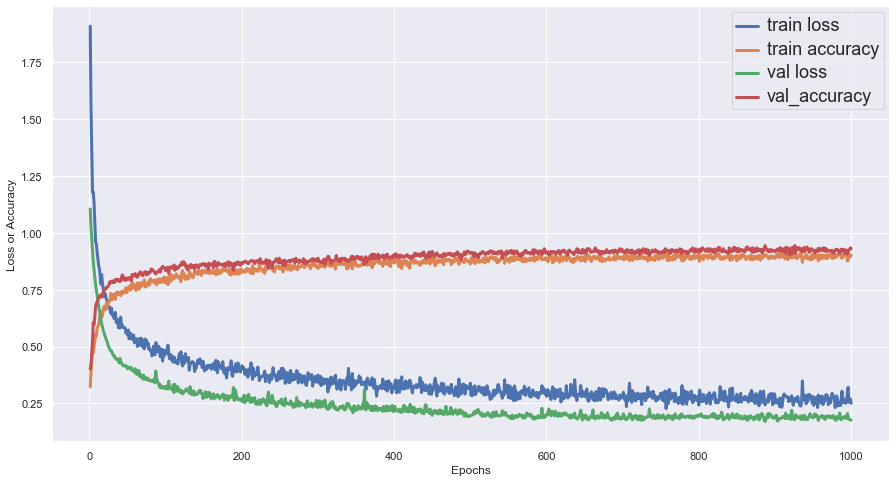

In [118]:
# plot the performance
epoch_num = range(1,epochs+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epoch_num,
                                  loss,accuracy,
                                  val_loss,
                                  val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text